In [ ]:
Using traditional machine learning regression models to predict nucleosome occupancy data for
the original Chromosome 1, the mean squared error and Pearson correlation coefficient values obtained from
each traditional machine learning model are compared with those of the improved convolutional neural network model,
and bar charts are drawn for visualization.

In [ ]:
Extract specific base sequences from the genomic sequence according to the nucleosome occupancy sites.

In [1]:
import numpy as np
import pandas as pd
with open('SAC1 Genome Deletion of Spaces/CH1n.txt',"r") as f:    
    strn = f.read() 
len(strn)
f = pd.read_csv('dMean Occupancy/CHr1.csv')
site = f['site']    
site = np.array(site)
print(site.shape)
level = f['value']    
level = np.array(level)
print(level.shape)
fh = open('Training Sequences/TS1.txt', 'w')
for i in range(len(site)):
    strs = strn[int(site[i])-74:int(site[i])+73]
    fh.write(strs)
    fh.write('\n')
fh.close()

(168234,)
(168234,)


In [ ]:
Convert the 147 bp DNA sequences at the nucleosome positions on the chromosome into 
one-hot encoded matrices of 16 dinucleotides,and save them as HDF5 files with labels.

In [2]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
Nuar = np.zeros((168234,16,146))
base = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
nonzero_indices = []
with open('Training Sequences/TS1.txt', 'r') as f:
    for i, line in enumerate(tqdm(f)):
        line = line.strip() 
        for n in range(16):  
            for m in range(len(line) - 1):
                dinu = line[m] + line[m+1]
                if dinu == base[n]:
                    nonzero_indices.append([i, n, m])
nonzero_indices = np.array(nonzero_indices, dtype=np.int32)
level=pd.read_csv("dMean Occupancy/CHr1.csv")
output_path = 'Training Feature Label Matrix/TM1.h5'
with h5py.File(output_path, 'w') as f:
    f.create_dataset('indices', data=nonzero_indices,compression='gzip',compression_opts=9)
    f.create_dataset('shape', data=[168234, 16, 146])
    f.create_dataset('label', data=level.iloc[:, 3],compression='gzip',compression_opts=6)

168234it [01:44, 1609.75it/s]


In [ ]:
Load the sparse matrix data from the HDF5 file, reconstruct it into a dense matrix, 
and then perform data preprocessing, including data format conversion, 
splitting into training and testing sets, and normalization, 
to prepare for training and testing of machine learning models.

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def load_dense_data(file_path):
    with h5py.File(file_path, 'r') as f:
        indices = f['indices'][:]
        shape = tuple(f['shape'][:])
        label = f['label'][:]
    dense_matrix = np.zeros(shape, dtype=np.float32)
    for i, n, m in indices:
        dense_matrix[i, n, m] = 1
    return dense_matrix.reshape(*shape), label
Nuar, label = load_dense_data('Training Feature Label Matrix/TM1.h5')
print(Nuar.shape)
print(label.shape)
X = Nuar.reshape(Nuar.shape[0], -1)
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(168234, 16, 146)
(168234,)


In [ ]:
Fit the training data using SGD regression, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [2]:
# SGD regression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred = sgd_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"SGD Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

SGD Regression - MSE: 0.1944, Pearson Correlation: 0.6998


In [ ]:
Fit the training data using Random Forest regression, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [3]:
# Random Forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
random_forest_model = RandomForestRegressor(n_estimators=200,max_depth=50,max_features='sqrt',n_jobs=4,random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Random Forest Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

Random Forest Regression - MSE: 0.2478, Pearson Correlation: 0.7405


In [ ]:
Fit the training data using the Ridge regression model, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [4]:
# Ridge regression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=10.0, tol=1e-6, solver='svd') 
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Ridge Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

Ridge Regression - MSE: 0.1396, Pearson Correlation: 0.7822


In [ ]:
Fit the training data using the Lasso regression model, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [5]:
# Lasso regression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([('scaler', StandardScaler()),  ('lasso', Lasso(max_iter=10000))])
parameters = {'lasso__alpha': np.logspace(-4, 2, 10)}
clf = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Lasso Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

Lasso Regression - MSE: 0.1394, Pearson Correlation: 0.7826


In [ ]:
Fit the training data using Elastic Net regression, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [6]:
# Elastic Net regression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
pipeline = make_pipeline(StandardScaler(), ElasticNet())
param_grid = {'elasticnet__alpha': [0.01, 0.1, 1.0],'elasticnet__l1_ratio': [0.1, 0.5, 0.9]}
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=2, verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Elastic Net Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

Elastic Net Regression - MSE: 0.1395, Pearson Correlation: 0.7826


In [ ]:
Fit the training data using LightGBM regression, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [7]:
# LightGBM regression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {'boosting_type': 'gbdt','objective': 'regression','metric': ['l2', 'rmse'],'num_leaves': 63,             
    'learning_rate': 0.1,'feature_fraction': 0.8,'bagging_fraction': 0.8,'bagging_freq': 5,'verbose': -1,               
    'seed': 42,'max_depth': 7, 'min_data_in_leaf': 30,'n_jobs': -1} 
gbm = lgb.train(params,train_data,num_boost_round=1000,valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False),lgb.log_evaluation(period=0)])
y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"LightGBM Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

LightGBM Regression - MSE: 0.1375, Pearson Correlation: 0.7861


In [ ]:
Fit the training data using XGBoost regression, make predictions on the test data, 
and calculate the mean squared error and Pearson correlation coefficient to evaluate the model's predictive performance.

In [8]:
# XGBoost regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'objective': 'reg:squarederror','learning_rate': 0.03,'max_depth': 8,'min_child_weight': 7,'subsample': 0.7,
    'colsample_bytree': 0.7,'gamma': 0.2,'reg_alpha': 0.5,'reg_lambda': 1.2,'tree_method': 'hist','seed': 42}
model = xgb.train(params,dtrain,num_boost_round=1500,evals=[(dtrain, 'train'), (dtest, 'test')],early_stopping_rounds=150,verbose_eval=False)
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"XGBoost Regression - MSE: {mse:.4f}, Pearson Correlation: {pearson_corr:.4f}")

XGBoost Regression - MSE: 0.1359, Pearson Correlation: 0.7919


In [ ]:
Draw bar charts to compare the mean squared error and Pearson correlation coefficient of 
various traditional machine learning models and the improved convolutional neural network model.

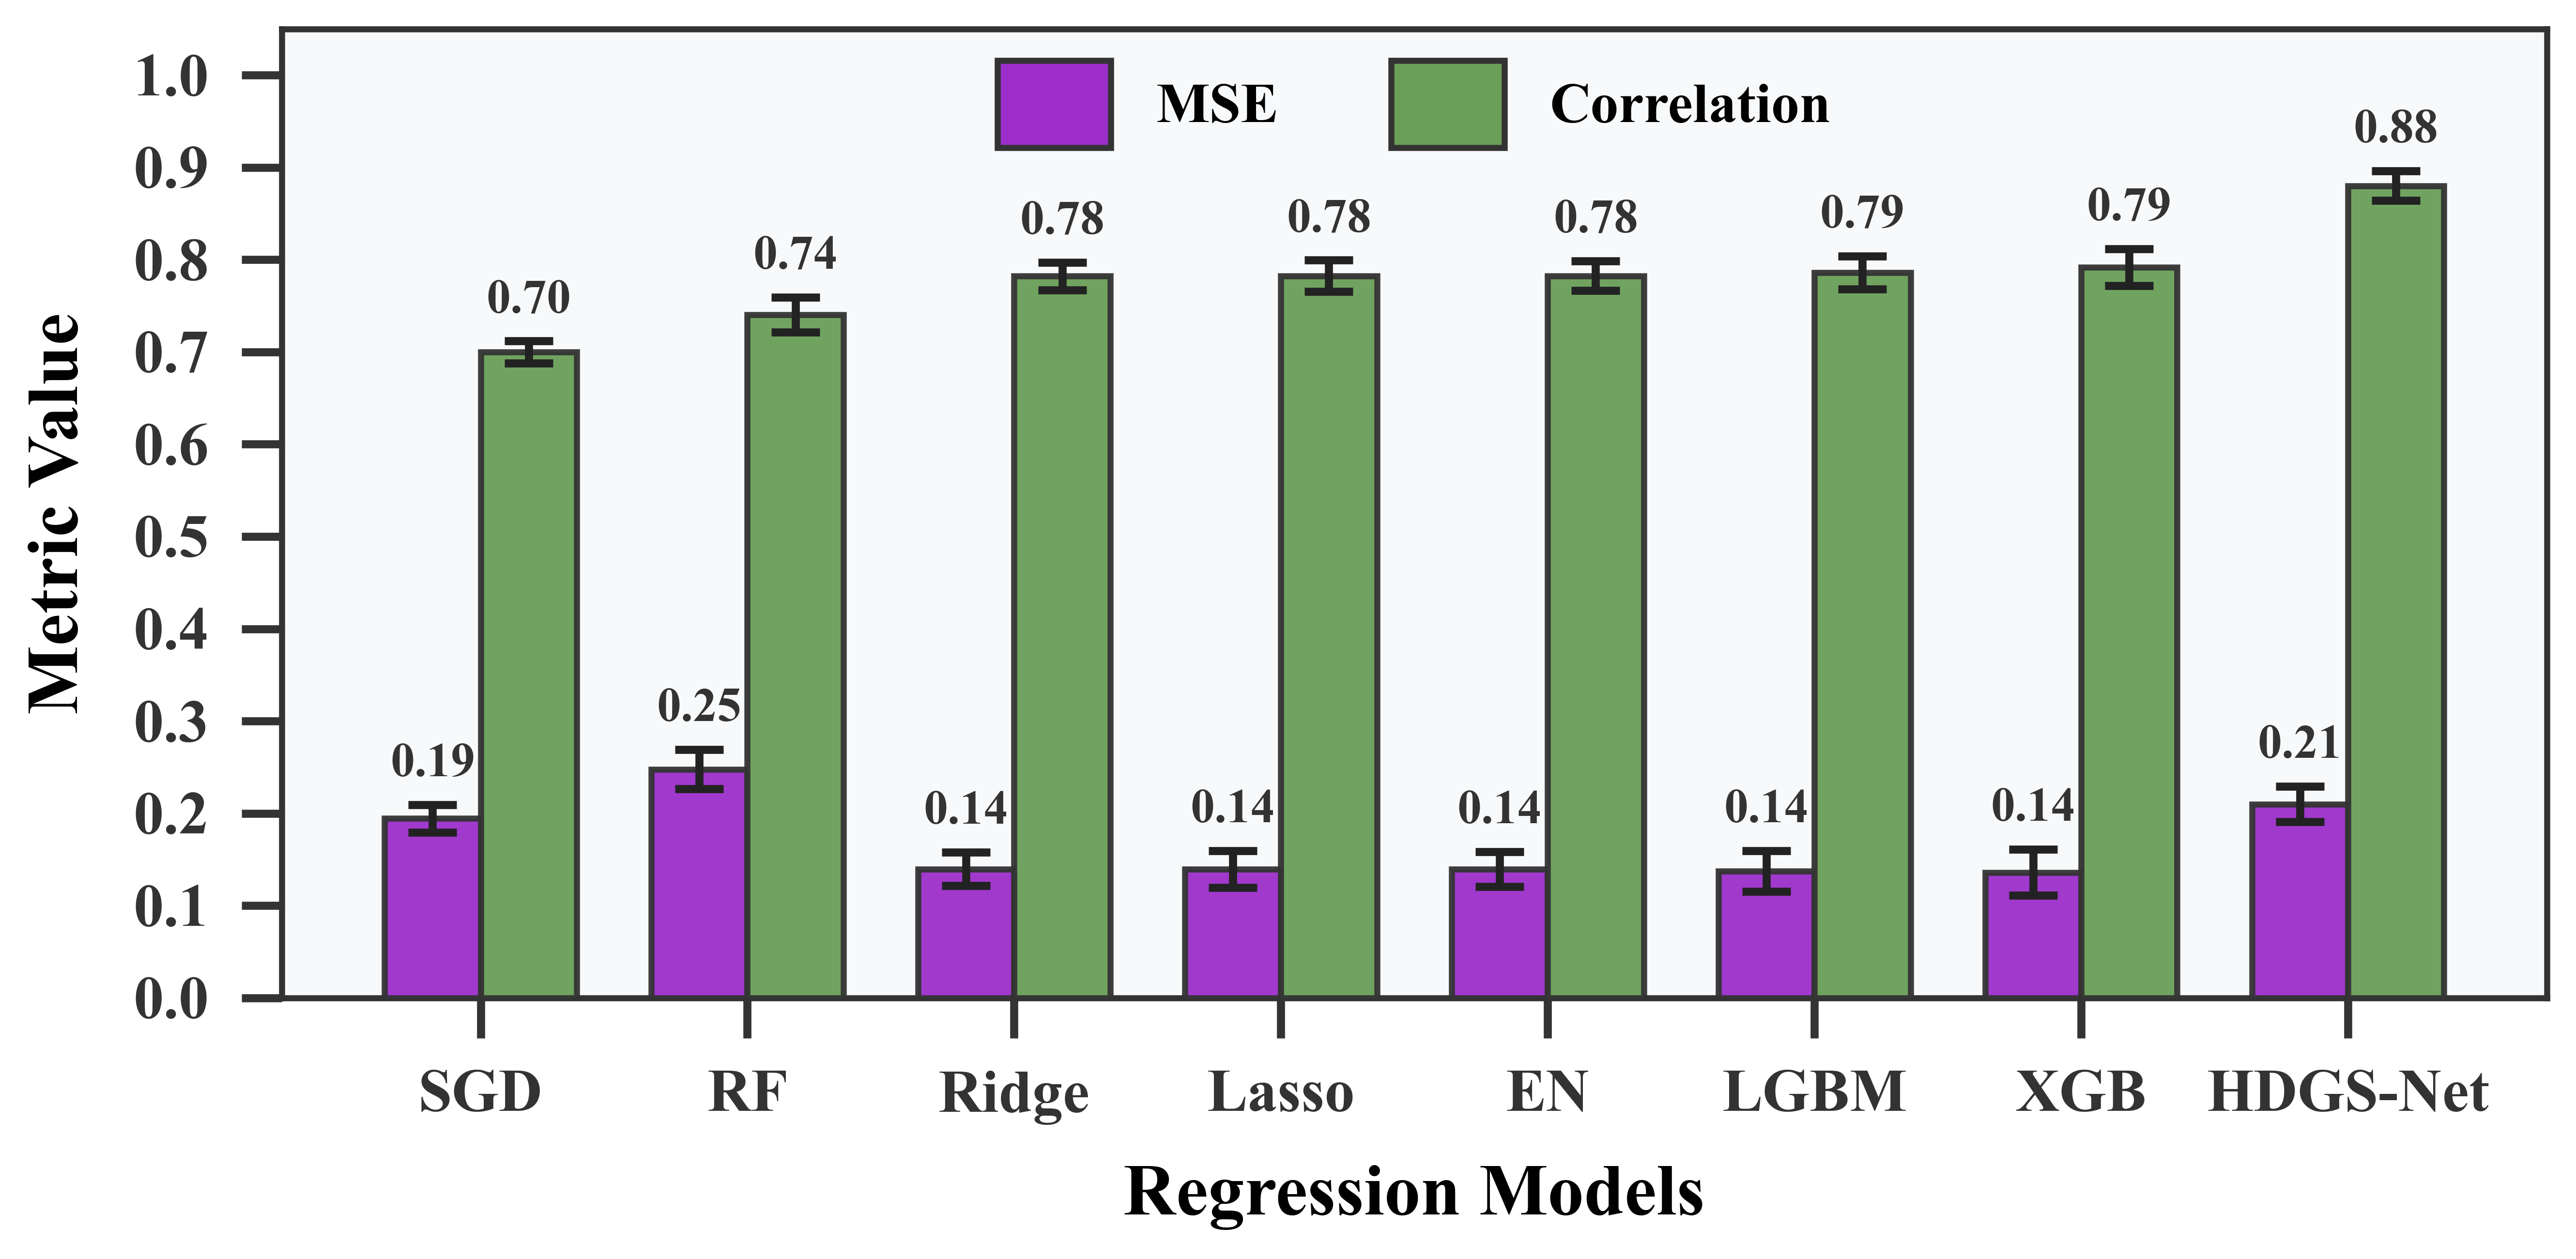

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# ---------------------- Advanced Font Configuration ----------------------
# Set global font to Times New Roman for publication quality
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['font.weight'] = 'bold' 
plt.rcParams['font.size'] = 16  

# ---------------------- Data Preparation ----------------------
# Define model performance data
data = {
    'Model': ['SGD', 'RF', 'Ridge', 'Lasso', 'EN', 'LGBM', 'XGB', 'HDGS-Net'],
    'MSE': [0.1944, 0.2478, 0.1396, 0.1394, 0.1395, 0.1375, 0.1359, 0.21],
    'Correlation': [0.6998, 0.7405, 0.7822, 0.7826, 0.7826, 0.7861, 0.7919, 0.88]}

# Define error data for each metric
errors = {
    'MSE': [0.015, 0.021, 0.018, 0.020, 0.019, 0.022, 0.025, 0.019],
    'Correlation': [0.012, 0.019, 0.015, 0.017, 0.016, 0.018, 0.020, 0.016]}

# Create DataFrames
df = pd.DataFrame(data)
df_errors = pd.DataFrame(errors)

# ---------------------- Advanced Chart Creation ----------------------
# Create figure with high DPI for publication quality
fig, ax = plt.subplots(figsize=(10, 6), dpi=600) 

# Enhance spine (border) appearance
for spine in ax.spines.values():
    spine.set_linewidth(1.5)  
    spine.set_color('#333333')  

# Set axis labels with bold font and reduced padding
ax.set_xlabel('Regression Models', fontsize=18, fontweight='bold', labelpad=10, fontname='Times New Roman')
ax.set_ylabel('Metric Value', fontsize=18, fontweight='bold', labelpad=10, fontname='Times New Roman')

# Configure tick parameters
ax.tick_params(axis='both', which='major', 
               length=10, width=2, 
               labelsize=14, pad=8,  # Reduced padding for tick labels
               colors='#333333', 
               labelcolor='#333333')  

# Set x-ticks with model names without rotation for better readability in publication
ax.set_xticks(np.arange(len(df['Model'])))
ax.set_xticklabels(df['Model'], rotation=0, ha='center', 
                   fontsize=15, fontweight='bold', fontname='Times New Roman')

# Set y-ticks from 0 to 1.0 with 0.1 intervals
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f"{tick:.1f}" for tick in np.arange(0, 1.1, 0.1)], 
                   fontsize=15, fontweight='bold', fontname='Times New Roman')
ax.set_ylim(0, 1.05)  

# Define professional color palette
colors = ['#9d2ecb', '#6a9f58']  

# Set bar width and positions
bar_width = 0.36
model_positions = np.arange(len(df['Model']))

# Plot bars for each metric with error bars
for i, metric in enumerate(['MSE', 'Correlation']):
    # Calculate offset for each metric group
    offset = bar_width * (i - 0.5)
    
    # Plot bars
    bars = ax.bar(model_positions + offset, df[metric], bar_width,
                  color=colors[i], edgecolor='#333333', linewidth=1.5,
                  zorder=3, alpha=0.95, label=metric)
    
    # Configure error bar appearance
    error_kw = dict(ecolor='#222222', elinewidth=2, capsize=6, capthick=2)
    
    # Add error bars
    ax.errorbar(model_positions + offset, df[metric], yerr=df_errors[metric],
                fmt='none', zorder=4, **error_kw)
    
    # Add value labels above bars
    for idx, bar in enumerate(bars):
        bar_height = bar.get_height()
        error_value = df_errors[metric].iloc[idx]
        
        # Calculate label position (above error bar)
        label_y = bar_height + error_value + 0.02 
        
        # Adjust position if too close to top
        if label_y > 1.0:
            label_y = bar_height - 0.03  
        # Add value label with bold font
        ax.text(bar.get_x() + bar.get_width()/2, label_y,
                f'{bar_height:.2f}',  
                ha='center', va='bottom', 
                fontsize=12, fontweight='bold',
                color='#333333', fontfamily='Times New Roman')

# Remove grid lines
ax.grid(False)

# Create legend elements with color patches
legend_elements = [
    mpl.patches.Patch(facecolor=colors[0], edgecolor='#333333', linewidth=1.5, label='MSE'),
    mpl.patches.Patch(facecolor=colors[1], edgecolor='#333333', linewidth=1.5, label='Correlation')]

# Add legend to the plot
ax.legend(handles=legend_elements, 
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.02), 
          ncol=2, 
          frameon=False, 
          prop={'family': 'Times New Roman', 'weight': 'bold', 'size': 14},
          handlelength=2, 
          handleheight=2)

# Set light background color for better contrast
ax.set_facecolor('#f8f9fa')

# Adjust layout for optimal spacing
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.8) 

# Save high-quality image
plt.savefig('Visualization Charts/Model_Performance_Comparison.png', dpi=600, bbox_inches='tight')
plt.show()